# 任务5 模型融合(3天)

 将特征放进模型中预测，并将预测结果作为新的特征加入原有特征中再经过模型预测结果（可以反复预测多次将结果加入最后的特征中）

In [2]:
from __future__ import print_function
import lightgbm as lgb
import sklearn
import numpy as np

from sklearn.model_selection import KFold
import pandas as pd
from sklearn.metrics import r2_score

In [3]:
X_train = pd.read_csv('../trainx.csv')
X_test = pd.read_csv('../testx.csv')
Y_train = pd.read_csv('../trainy.csv', header=None)
Y_test = pd.read_csv('../testy.csv', header=None)

feature = X_train
label = Y_train.values.reshape(-1)
test = X_test
categorical_feats = list(feature.columns)

In [4]:
params = {
    'objective': 'regression',
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,

    'lambda_l1': 0.01,
    'lambda_l2': 10,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 4, 
}

In [17]:
    from sklearn.model_selection import KFold
    folds = KFold(n_splits=3, shuffle=True, random_state=2333)
   
    "===================================第一轮========================================================"
    y_pre_list = []
    r2_list = []
    train_feat = pd.Series()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(feature.values, label)):
        print("fold {}".format(fold_))
        # trn_data = lgb.Dataset(feature.iloc[trn_idx], label[trn_idx], categorical_feature=categorical_feats)
        # val_data = lgb.Dataset(feature.iloc[val_idx], label[val_idx], categorical_feature=categorical_feats)
        trn_data = lgb.Dataset(feature.iloc[trn_idx], label[trn_idx], feature_name=categorical_feats)
        val_data = lgb.Dataset(feature.iloc[val_idx], label[val_idx], feature_name=categorical_feats)

        num_round = 10000
        clf = lgb.train(params, trn_data, num_round,valid_sets=[trn_data, val_data], verbose_eval=500,
                    early_stopping_rounds=200)
        y_pre = clf.predict(feature.iloc[val_idx], num_iteration=clf.best_iteration)
        r2 = r2_score(y_pre,label[val_idx])
        r2_list.append(r2)
        train_feat = train_feat.append(pd.Series(y_pre,index=val_idx))
        y_pre_test = clf.predict(test,num_iteration=clf.best_iteration)
        y_pre_list.append(y_pre_test)
    print('r2 score{:}'.format(r2))
    print('r2:{:}'.format(np.mean(r2_list)))

    y_pred_final=  (y_pre_list[0]+y_pre_list[1]+y_pre_list[2]+y_pre_list[3]+y_pre_list[4])/5
    feature['pre'] = train_feat
    test['pre'] = y_pred_final
    "===================================第二轮========================================================"
    y_pre_list = []
    r2_list = []
    train_feat = pd.Series()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(feature.values, label)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(feature.iloc[trn_idx], label[trn_idx], feature_name=categorical_feats)
        val_data = lgb.Dataset(feature.iloc[val_idx], label[val_idx], feature_name=categorical_feats)

        num_round = 10000
        clf = lgb.train(params, trn_data, num_round, feval=get_r2_metric,valid_sets=[trn_data, val_data], verbose_eval=500,
                    early_stopping_rounds=200)
        y_pre = clf.predict(feature.iloc[val_idx], num_iteration=clf.best_iteration)
        r2 = r2_score(y_pre,label[val_idx])
        r2_list.append(r2)
        train_feat = train_feat.append(pd.Series(y_pre,index=val_idx))
        y_pre_test = clf.predict(test,num_iteration=clf.best_iteration)
        y_pre_list.append(y_pre_test)
    print('r2 score{:}'.format(r2))
    print('r2:{:}'.format(np.mean(r2_list)))
    
    y_pred_final=  (y_pre_list[0]+y_pre_list[1]+y_pre_list[2]+y_pre_list[3]+y_pre_list[4])/5
    feature['pre_2'] = train_feat
    test['pre_2'] = y_pred_final
    "=======================第三轮========================================================"
    y_pre_list = []
    r2_list = []
    train_feat = pd.Series()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(feature.values, label)):
        print("fold {}".format(fold_))
        trn_data = lgb.Dataset(feature.iloc[trn_idx], label[trn_idx], feature_name=categorical_feats)
        val_data = lgb.Dataset(feature.iloc[val_idx], label[val_idx], feature_name=categorical_feats)

        num_round = 10000
        clf = lgb.train(params, trn_data, num_round, feval=get_r2_metric,valid_sets=[trn_data, val_data], verbose_eval=500,
                    early_stopping_rounds=200)
        y_pre = clf.predict(feature.iloc[val_idx], num_iteration=clf.best_iteration)
        r2 = r2_score(y_pre,label[val_idx])
        r2_list.append(r2)
        train_feat = train_feat.append(pd.Series(y_pre,index=val_idx))
        y_pre_test = clf.predict(test,num_iteration=clf.best_iteration)
        y_pre_list.append(y_pre_test)
    print('r2 score{:}'.format(r2))
    print('r2:{:}'.format(np.mean(r2_list)))
    
    y_pred_final=  (y_pre_list[0]+y_pre_list[1]+y_pre_list[2]+y_pre_list[3]+y_pre_list[4])/5
    
    return y_pred_final


fold 0
Training until validation scores don't improve for 200 rounds.
[500]	training's l2: 312647	valid_1's l2: 593375
[1000]	training's l2: 216667	valid_1's l2: 577079
[1500]	training's l2: 166147	valid_1's l2: 575640
Early stopping, best iteration is:
[1314]	training's l2: 181942	valid_1's l2: 575116
fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's l2: 324870	valid_1's l2: 552350
[1000]	training's l2: 222797	valid_1's l2: 535237
[1500]	training's l2: 171666	valid_1's l2: 534020
Early stopping, best iteration is:
[1434]	training's l2: 176831	valid_1's l2: 533020
fold 2
Training until validation scores don't improve for 200 rounds.
[500]	training's l2: 318611	valid_1's l2: 583010
[1000]	training's l2: 221888	valid_1's l2: 561721
[1500]	training's l2: 171151	valid_1's l2: 559572
Early stopping, best iteration is:
[1477]	training's l2: 173039	valid_1's l2: 559179
r2 score0.9010301854471349
r2:0.9023333234999357


IndexError: list index out of range

In [13]:
train_feat.shape
feature.shape
pd.Series(y_pre,index=val_idx).shape

(13378,)

# pre1-pren分别是n组模型预测出来的结果，将其进行加权融合



In [ ]:
pre = (pre1 + pre2 + pre3 +...+pren )/n

pd.DataFrame(pre).to_csv("pre.csv",header=None,index=None)


# blending



In [2]:
def blend(train,test,target):
    '''5折'''
    # n_flods = 5
    # skf = list(StratifiedKFold(y, n_folds=n_flods))
    '''切分训练数据集为d1,d2两部分'''
    X_d1, X_d2, y_d1, y_d2 = train_test_split(train, target, test_size=0.5, random_state=914)

    train_ = np.zeros((X_d2.shape[0],len(clfs*3)))
    test_ = np.zeros((test.shape[0],len(clfs*3)))

    for j,clf in enumerate(clfs):
        '''依次训练各个单模型'''
        # print(j, clf)
        '''使用第1个部分作为预测，第2部分来训练模型，获得其预测的输出作为第2部分的新特征。'''
        # X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
        X_d1fillna=X_d1.fillna(0)
        X_d2fillna = X_d2.fillna(0)

        X_predictfillna= test.fillna(0)

        clf.fit(X_d1fillna,y_d1)
        y_submission = clf.predict(X_d2fillna)
        y_test_submission = clf.predict(X_predictfillna)

        train_[:,j*3] = y_submission*y_submission
        '''对于测试集，直接用这k个模型的预测值作为新的特征。'''
        test_[:, j*3] = y_test_submission*y_test_submission

        train_[:, j+1] =(y_submission - y_submission.min()) /(y_submission.max() - y_submission.min())
        '''对于测试集，直接用这k个模型的预测值作为新的特征。'''
        y_test_submission = (y_test_submission - y_test_submission.min()) / \
                            (y_test_submission.max() - y_test_submission.min())
        test_[:, j+1] = y_test_submission

        train_[:, j+2] = np.log(y_submission)
        '''对于测试集，直接用这k个模型的预测值作为新的特征。'''
        y_test_submission =np.log(y_test_submission)
        test_[:, j+2] = y_test_submission



        # print("val auc Score: %f" % r2_score(y_predict, dataset_d2[:, j]))
        print('已完成第',j)

    train_.to_csv('./input/train_blending.csv', index=False)
    test_.to_csv('./input/test_blending.csv', index=False)


# Stacking

In [1]:
#!pip install mlxtend

import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

[0.92 0.9  0.9 ]
Accuracy: 0.91 (+/- 0.01) [KNN]
[0.96 0.94 0.96]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
[0.9  0.9  0.94]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
[0.96 0.92 0.96]
Accuracy: 0.95 (+/- 0.02) [Stacking Classifier]


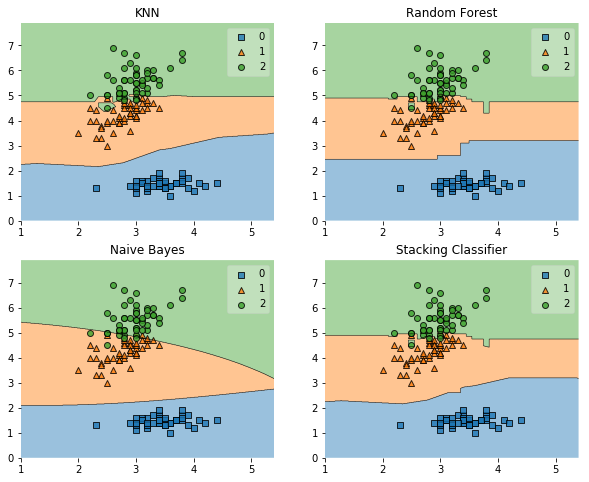

In [3]:
# 以python自带的鸢尾花数据集为例
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print(scores)
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)

plt.show()